In [24]:
import os
import sys

import pandas as pd
import numpy as np
import pickle
import unsupervised_learning_util as utl
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS, Isomap, SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.metrics import homogeneity_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from warnings import simplefilter

plt.tight_layout()
plt.style.use("ggplot")
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 500


NJOBS = 32
VERBOSE = 0

%matplotlib inline

In [ ]:
gathered_data = utl.setup(["MNIST"])
mnist_scaled = {}
mnist_scaled['train_X'], mnist_scaled['train_y'], \
mnist_scaled['valid_X'], mnist_scaled['valid_y'], \
mnist_scaled['test_X'], mnist_scaled['test_y'] = utl.split_data(gathered_data["MNIST"]["X"],
                                                                gathered_data["MNIST"]["y"], scale=True)
mnist_not_scaled = {}
mnist_not_scaled['train_X'], mnist_not_scaled['train_y'], \
mnist_not_scaled['valid_X'], mnist_not_scaled['valid_y'], \
mnist_not_scaled['test_X'], mnist_not_scaled['test_y'] = utl.split_data(gathered_data["MNIST"]["X"],
                                                                        gathered_data["MNIST"]["y"], 
                                                                        scale=False)


# Determine Scaling

In [ ]:
temp_folder = "Clustering/" + "KMeans/"
utl.check_folder(temp_folder)
save_dir = os.getcwd() + temp_folder
limit = 5000
idx = [i for i in range(2, 15, 2)]
cols = [limit]


inertia_results_scaled = pd.DataFrame(columns=["Scaled"],
                               index=idx,
                               data=np.zeros(shape=(len(idx), len(cols))))
inertia_results_not_scaled = pd.DataFrame(columns=["Not Scaled"],
                               index=idx,
                               data=np.zeros(shape=(len(idx), len(cols))))

silhouette_average_results_scaled = pd.DataFrame(columns=["Scaled"], index=idx,
                                          data=np.zeros(shape=(len(idx), len(cols))))
silhouette_average_results_not_scaled = pd.DataFrame(columns=["Not Scaled"], index=idx,
                                          data=np.zeros(shape=(len(idx), len(cols))))
silhouette_sample_results_scaled = {}
silhouette_sample_results_not_scaled = {}
best_inertia = -1e12
best_inertia_num_cluster = 0
best_silhouette = 0
best_silhouette_num_cluster = 0
print("Starting K-Means Clustering")

for _df in ["Scaled", "Not Scaled"]:
    for k in idx:
        print(f"\t\t{_df} Number of Clusters: {k}")
        if _df == "Scaled":
            temp_train_X = mnist_scaled["train_X"].iloc[:limit, :]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            inertia_results_scaled.loc[k, "Scaled"] = inertia
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_)
            silhouette_average_results_scaled.loc[k, "Scaled"] = silhouette_average
            temp_silhouette_sample_results = silhouette_samples(temp_train_X, k_means.labels_)
            silhouette_sample_results_scaled[f"NumClusters_{k} DataSize_{limit}"] = temp_silhouette_sample_results
            print(f"\t{_df} Current Intertia: {inertia}, Silhouette: {silhouette_average}")
            if inertia > best_inertia:
                best_inertia = inertia
                best_inertia_num_cluster = k
                print(f"\t{_df} New Best Inertia: {best_inertia}")
                print(f"\t\t{_df} Inertia Best Number of Clusters: {best_inertia_num_cluster}")
            if silhouette_average > best_silhouette:
                best_silhouette = silhouette_average
                best_silhouette_num_cluster = k
                print(f"\t{_df} New Best Silhouette: {best_silhouette}")
                print(f"\t\t{_df} Silhouette Best Number of Clusters: {best_silhouette_num_cluster}")
        elif _df == "Not Scaled":
            temp_train_X = mnist_not_scaled["train_X"].iloc[:limit, :]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            inertia_results_not_scaled.loc[k, "Not Scaled"] = inertia
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_)
            silhouette_average_results_not_scaled.loc[k, "Not Scaled"] = silhouette_average
            temp_silhouette_sample_results = silhouette_samples(temp_train_X, k_means.labels_)
            silhouette_sample_results_not_scaled[f"NumClusters_{k} DataSize_{limit}"] = temp_silhouette_sample_results
            print(f"\t{_df} Current Intertia: {inertia}, Silhouette: {silhouette_average}")
            if inertia > best_inertia:
                best_inertia = inertia
                best_inertia_num_cluster = k
                print(f"\t{_df} New Best Inertia: {best_inertia}")
                print(f"\t\t{_df} Inertia Best Number of Clusters: {best_inertia_num_cluster}")
            if silhouette_average > best_silhouette:
                best_silhouette = silhouette_average
                best_silhouette_num_cluster = k
                print(f"\t{_df} New Best Silhouette: {best_silhouette}")
                print(f"\t\t{_df} Silhouette Best Number of Clusters: {best_silhouette_num_cluster}")


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

inertia_results_scaled.plot(ax=ax1, label="Scaled")
inertia_results_not_scaled.plot(ax=ax1, label="Not Scaled")
ax1.set_title(f"K Means Clustering\nInertia", fontsize=15, weight='bold')
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax1.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax1.set_ylabel("Inertia", fontsize=15, weight='heavy')
ax1.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

silhouette_average_results_scaled.plot(ax=ax2, label="Scale")
silhouette_average_results_not_scaled.plot(ax=ax2, label="Not Scaled")
ax2.set_title(f"K Means Clusters\nSilhouette", fontsize=15, weight='bold')
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax2.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax2.set_ylabel("Average Silhouette Score", fontsize=15, weight='heavy')
ax2.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

plt.savefig(f"{os.getcwd()}/{temp_folder}KMEans_Combined_Scaled_Vs_NotScaled.png", bbox_inches='tight')
plt.close("all")

# K-Means Clustering

In [2]:
gathered_data = utl.setup(["MNIST"])
gathered_data_fashion = utl.setup(["Fashion-MNIST"])
mnist = {}
fashion_mnist = {}
mnist['train_X'], mnist['train_y'], \
mnist['valid_X'], mnist['valid_y'], \
mnist['test_X'], mnist['test_y'] = utl.split_data(gathered_data["MNIST"]["X"], gathered_data["MNIST"]["y"], scale=True)

fashion_mnist['train_X'], fashion_mnist['train_y'], \
fashion_mnist['valid_X'], fashion_mnist['valid_y'], \
fashion_mnist['test_X'], fashion_mnist['test_y'] = utl.split_data(gathered_data_fashion["Fashion-MNIST"]["X"],
                                                                  gathered_data_fashion["Fashion-MNIST"]["y"], scale=True)

dataset folder already exists.
MNIST dataset found:
	Loading MNIST.feather
	Finished loading MNIST dataset
dataset folder already exists.
Fashion-MNIST dataset found:
	Loading Fashion-MNIST.feather
	Finished loading Fashion-MNIST dataset


In [43]:
temp_folder = "Clustering/" + "KMeans/"
utl.check_folder(temp_folder)
save_dir = os.getcwd() + temp_folder
limit = 5000
idx = [i for i in range(2, 51, 1)]
cols = ["Inertia", "Silhouette", "Homogeneity", "Completeness", "Harmonic_Mean", "Calinski_Harabasz", "Davies_Bouldin"]

C:\Users\joshu\OneDrive - Georgia Institute of Technology\Georgia-Tech\CS 7641 - Machine Learning\Assignments\Unsupervised Learning and Dimensionality Reduction\Clustering/KMeans/ folder already exists.


In [44]:
mnist_results = pd.DataFrame(columns=cols, index=idx,
                               data=np.zeros(shape=(len(idx), len(cols))))

fashion_results = pd.DataFrame(columns=cols, index=idx,
                                          data=np.zeros(shape=(len(idx), len(cols))))

print("Starting K-Means Clustering")
for _df in ["MNIST", "Fashion-MNIST"]:
    for k in idx:
        if _df == "MNIST":
            temp_train_X = mnist["train_X"].iloc[:limit, :]
            temp_train_y = mnist["train_y"].iloc[:limit]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_, metric="euclidean")
            y_pred = k_means.predict(temp_train_X)
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(temp_train_y, y_pred)
            mnist_results.loc[k, "Inertia"] = inertia
            mnist_results.loc[k, "Silhouette"] = silhouette_average
            mnist_results.loc[k, "Calinski_Harabasz"] = calinski_harabasz_score(temp_train_X, k_means.labels_)
            mnist_results.loc[k, "Davies_Bouldin"] = davies_bouldin_score(temp_train_X, k_means.labels_)
            mnist_results.loc[k, "Homogeneity"] = homogeneity
            mnist_results.loc[k, "Completeness"] = completeness
            mnist_results.loc[k, "Harmonic_Mean"] = v_measure
            print(f"\t{_df} - k={k} \n\t\tCurrent Intertia: {inertia}, Silhouette: {silhouette_average}")

        elif _df == "Fashion-MNIST":
            temp_train_X = fashion_mnist["train_X"].iloc[:limit, :]
            temp_train_y = fashion_mnist["train_y"].iloc[:limit]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_, metric="euclidean")
            y_pred = k_means.predict(temp_train_X)
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(temp_train_y, y_pred)
            fashion_results.loc[k, "Inertia"] = inertia
            fashion_results.loc[k, "Silhouette"] = silhouette_average
            fashion_results.loc[k, "Calinski_Harabasz"] = calinski_harabasz_score(temp_train_X, k_means.labels_)
            fashion_results.loc[k, "Davies_Bouldin"] = davies_bouldin_score(temp_train_X, k_means.labels_)
            fashion_results.loc[k, "Homogeneity"] = homogeneity
            fashion_results.loc[k, "Completeness"] = completeness
            fashion_results.loc[k, "Harmonic_Mean"] = v_measure
            print(f"\t{_df} - k={k} \n\t\tCurrent Intertia: {inertia}, Silhouette: {silhouette_average}")


Starting K-Means Clustering
	MNIST - k=2 
		Current Intertia: 2613311222.1597886, Silhouette: 0.3183680585811602
	MNIST - k=3 
		Current Intertia: 2425580862.0674343, Silhouette: 0.26203777366205155
	MNIST - k=4 
		Current Intertia: 2310841944.4091105, Silhouette: 0.22392965419771504
	MNIST - k=5 
		Current Intertia: 2220441126.234953, Silhouette: 0.21154635378704775
	MNIST - k=6 
		Current Intertia: 2151047121.109139, Silhouette: 0.15726623842001855
	MNIST - k=7 
		Current Intertia: 2089361778.5040455, Silhouette: 0.16138985933674388
	MNIST - k=8 
		Current Intertia: 2034898573.3966892, Silhouette: 0.1605437256926702
	MNIST - k=9 
		Current Intertia: 1995909362.5084527, Silhouette: 0.16388378589752237
	MNIST - k=10 
		Current Intertia: 1960267162.5389783, Silhouette: 0.08897581270389046
	MNIST - k=11 
		Current Intertia: 1923180817.0297902, Silhouette: 0.06462804568032159
	MNIST - k=12 
		Current Intertia: 1888464490.0787838, Silhouette: 0.058586229522689805
	MNIST - k=13 
		Current I

	Fashion-MNIST - k=44 
		Current Intertia: 515868796.74598056, Silhouette: 0.2345928868413384
	Fashion-MNIST - k=45 
		Current Intertia: 512684531.5178452, Silhouette: 0.2196069329753328
	Fashion-MNIST - k=46 
		Current Intertia: 509512075.9822041, Silhouette: 0.2199183787415913
	Fashion-MNIST - k=47 
		Current Intertia: 505832131.0120216, Silhouette: 0.2200982378753662
	Fashion-MNIST - k=48 
		Current Intertia: 502146119.7081742, Silhouette: 0.22113083405720713
	Fashion-MNIST - k=49 
		Current Intertia: 498971463.41298115, Silhouette: 0.2211905482361007
	Fashion-MNIST - k=50 
		Current Intertia: 497591594.93433756, Silhouette: 0.21991407379416514


In [47]:
temp = fashion_results / fashion_results.iloc[0]

<AxesSubplot:>

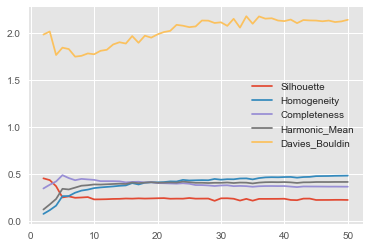

In [48]:
fashion_results[["Silhouette", "Homogeneity", "Completeness", "Harmonic_Mean","Davies_Bouldin"]].plot()

<AxesSubplot:>

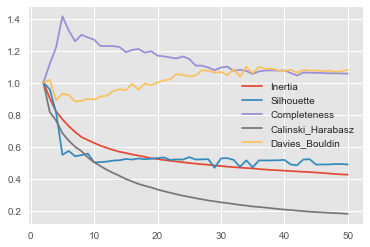

In [49]:
temp[["Inertia", "Silhouette", "Completeness", "Calinski_Harabasz", "Davies_Bouldin"]].plot()

In [45]:
with open(f"{os.getcwd()}/{temp_folder}/MNIST_Results.pkl", "wb") as out_file:
    pickle.dump(mnist_results, out_file)
    out_file.close()

In [46]:
with open(f"{os.getcwd()}/{temp_folder}/Fashion_Results.pkl", "wb") as out_file:
    pickle.dump(fashion_results, out_file)
    out_file.close()

## Elbow Method

In [ ]:
plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1_secondary = ax1.twinx()
ax2_secondary = ax2.twinx()

mnist_model = KMeans(verbose=VERBOSE, random_state=42)
mnist_visualizer = KElbowVisualizer(mnist_model, k=(2, 51), ax=ax1, timings=False)
mnist_visualizer.fit(mnist["train_X"].iloc[:limit, :])

fashion_model = KMeans(verbose=VERBOSE, random_state=42)
fashion_visualizer = KElbowVisualizer(fashion_model, k=(2, 51), ax=ax2, timings=False)
fashion_visualizer.fit(fashion_mnist["train_X"].iloc[:limit, :])

mnist_results[["Silhouette", "Homogeneity", "Completeness", "Harmonic_Mean","Davies_Bouldin"]].plot(ax=ax1_secondary, linestyle="--")
mnist_results[["Inertia"]].plot(ax=ax1, linestyle="--")
ax1.set_title(f"K Means Clustering\nDistortion MNIST", fontsize=15, weight='bold')
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax1.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax1.set_ylabel("Distortion", fontsize=15, weight='heavy')
ax1.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

fashion_results[["Silhouette", "Homogeneity", "Completeness", "Harmonic_Mean","Davies_Bouldin"]].plot(ax=ax2_secondary, linestyle="--")
fashion_results[["Inertia"]].plot(linestyle="--", ax=ax2)
ax2.set_title(f"K Means Clusters\nDistortion Fashion MNIST", fontsize=15, weight='bold')
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax2.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax2.set_ylabel("Distortion", fontsize=15, weight='heavy')
ax2.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

plt.savefig(f"{os.getcwd()}/{temp_folder}KMEans_Inertia_Elbow_Combined.png", bbox_inches='tight')

## Silhouette Method

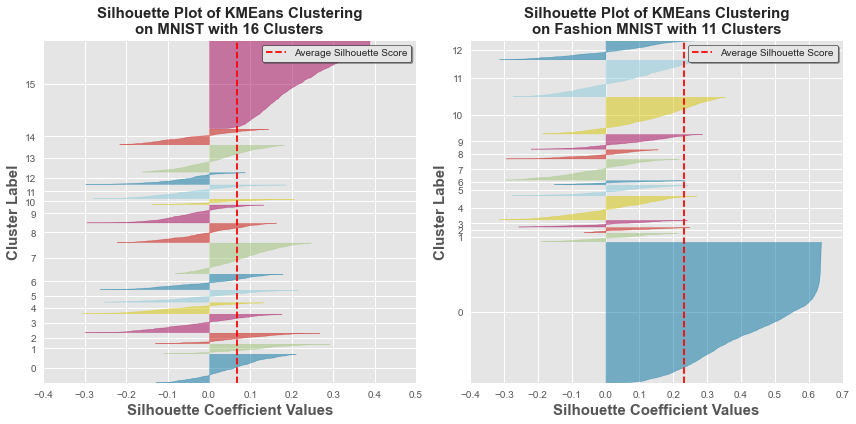

In [51]:
plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

mnist_model = KMeans(n_clusters=16, random_state=42)
fashion_model = KMeans(n_clusters=13, random_state=42)

mnist_vis = SilhouetteVisualizer(mnist_model, ax=ax1, colors='yellowbrick').fit(mnist["train_X"].iloc[:limit, :]).finalize()
fashion_mnist_vis = SilhouetteVisualizer(fashion_model, ax=ax2, colors='yellowbrick').fit(fashion_mnist["train_X"].iloc[:limit, :]).finalize()

ax1.set_title(f"Silhouette Plot of KMEans Clustering\non MNIST with 16 Clusters", fontsize=15, weight='bold')
ax1.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
ax1.set_xlabel("Silhouette Coefficient Values", fontsize=15, weight='heavy')
ax1.set_ylabel("Cluster Label", fontsize=15, weight='heavy')

ax2.set_title(f"Silhouette Plot of KMEans Clustering\non Fashion MNIST with 11 Clusters", fontsize=15, weight='bold')
ax2.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
ax2.set_xlabel("Silhouette Coefficient Values", fontsize=15, weight='heavy')
ax2.set_ylabel("Cluster Label", fontsize=15, weight='heavy')

plt.tight_layout()

plt.savefig(f"{os.getcwd()}/{temp_folder}KMEans_Silhouette_Combined.png", bbox_inches='tight')

# Expectation Maximization 